In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


# 데이터 전처리

### 데이터 특성에 따른 항목 정의

1. SessionId 항목
    - 설명 : UserId로 rating을 평가해도, 시간이 지나면 평가가 달라진다는 생각에 착안하여 session기간을 설정
    - 구성 : session 기간 기준으로 SessionID를 설정
        - session 기간은 1달로 설정 (영화 취향은 매일 달라지지 않으므로)
        - "UserId + 월"를 SessionID 역할로 설정
            - 즉, UserId_월 1개 = Session 1개
2. Time 항목
    - 바로 분석할 수 있도록 Time 항목 포맷을 Timestamp인 포맷을 UTC로 변경
    - Time 시간 데이터를 보고 무분별한 데이터는 제거할 예정
3. Rating 항목
    - Rating 데이터를 평가한 데이터를 보고 무분별한 데이터는 제거할 예정


### Time 포맷 변경 

- timestamp -> UTC 

In [3]:
from datetime import datetime

# timestamp -> UTC 로 포맷 변경 테스트
timestamp = 978300019
dt_object = datetime.utcfromtimestamp(timestamp)

print(dt_object)

2000-12-31 22:00:19


In [4]:
data.Time = data.Time.apply(lambda t: datetime.utcfromtimestamp(t))

In [5]:
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


### SessionId 설정

- "UserId + 월"를 SessionID 역할로 설정
- 즉, UserId_월 1개 = Session 1개

In [6]:
for idx, userId, time in zip(data.index, data['UserId'], data['Time']):
    data.at[idx, 'SessionId'] = str(userId) + '_' + str(time.strftime('%Y%m')) # %Y%m%d

In [7]:
data

,UserId,ItemId,Rating,Time,SessionId
31,1,3186,4,2000-12-31 22:00:19,1_200012
22,1,1270,5,2000-12-31 22:00:55,1_200012
27,1,1721,4,2000-12-31 22:00:55,1_200012
37,1,1022,5,2000-12-31 22:00:55,1_200012
24,1,2340,3,2000-12-31 22:01:43,1_200012
...,...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29,6040_200108
999988,6040,1921,4,2001-08-10 14:41:04,6040_200108
1000172,6040,1784,3,2001-08-10 14:41:04,6040_200108
1000167,6040,161,3,2001-08-10 14:41:26,6040_200108


### 유저수 & 세션수 & 아이템 

- 유저수 : 6040
- 세션수 : 13119
- 아이템 : 3706개

In [8]:
data['UserId'].nunique(), data['SessionId'].nunique(), data['ItemId'].nunique()

(6040, 13235, 3706)

### 세션의 rating 클릭 횟수 확인

In [9]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
1000_200011     84
1001_200011     91
1001_200012    274
1001_200101      4
1001_200102      2
              ... 
99_200012       14
99_200101        5
99_200102       51
99_200107       37
9_200012       106
Length: 13235, dtype: int64

#### 세션의 rating 클릭 횟수

In [10]:
session_length.median(), session_length.mean()

(27.0, 75.57302606724593)

#### 세션의 rating 클릭 횟수 최소-최대

In [11]:
session_length.min(), session_length.max()

(1, 1849)

#### 세션 99.9% 영화 rating을 평가

In [12]:
session_length.quantile(0.999)

1072.6180000000331

#### max rating한 세션 데이터 확인해보기

In [13]:
long_session = session_length[session_length==1849].index[0]
data[data['SessionId']==long_session]

,UserId,ItemId,Rating,Time,SessionId
278445,1680,3940,3,2000-11-20 08:20:46,1680_200011
279415,1680,858,2,2000-11-20 08:20:46,1680_200011
279596,1680,2395,4,2000-11-20 08:20:46,1680_200011
278591,1680,3051,3,2000-11-20 08:21:46,1680_200011
278855,1680,2628,2,2000-11-20 08:21:46,1680_200011
...,...,...,...,...,...
280102,1680,3753,1,2000-11-21 22:15:14,1680_200011
278469,1680,1266,5,2000-11-21 22:15:53,1680_200011
279644,1680,3508,4,2000-11-21 22:16:08,1680_200011
280169,1680,553,1,2000-11-21 22:16:25,1680_200011


In [14]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1       0.100340
2       0.168493
3       0.217832
4       0.252815
5       0.282811
          ...   
1008    0.998640
1009    0.998716
1016    0.998791
1026    0.998867
1055    0.998942
Length: 656, dtype: float64

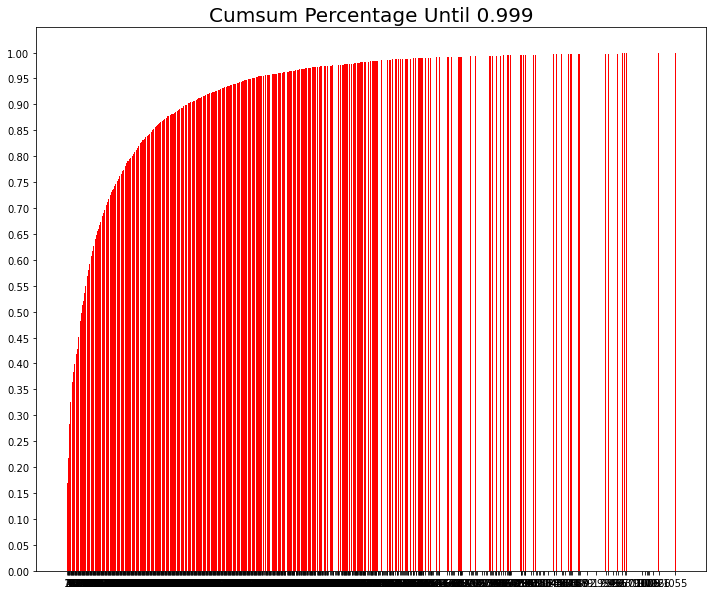

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### Item 데이터 확인

In [16]:
item_popular = data.groupby('ItemId').size()
item_popular

ItemId
1       2077
2        701
3        478
4        170
5        296
        ... 
3948     862
3949     304
3950      54
3951      40
3952     388
Length: 3706, dtype: int64

In [17]:
item_popular.median(), item_popular.mean()

(123.5, 269.88909875876953)

In [18]:
item_popular.min(), item_popular.max()

(1, 3428)

### Session Time (rating 기준)

- 원본 데이터는 약 3년치 데이터

In [19]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


### Data Cleansing

- 최소 2번 이상 rating한 데이터를 유효하다고 봄
- 아이템 갯수는 최소 5개 이상인 데이터만 추림 

In [20]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [21]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time,SessionId
31,1,3186,4,2000-12-31 22:00:19,1_200012
22,1,1270,5,2000-12-31 22:00:55,1_200012
27,1,1721,4,2000-12-31 22:00:55,1_200012
37,1,1022,5,2000-12-31 22:00:55,1_200012
24,1,2340,3,2000-12-31 22:01:43,1_200012
...,...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29,6040_200108
999988,6040,1921,4,2001-08-10 14:41:04,6040_200108
1000172,6040,1784,3,2001-08-10 14:41:04,6040_200108
1000167,6040,161,3,2001-08-10 14:41:26,6040_200108


---

# Train, Valid, Test 데이터 구성

- 3개월 기준으로 test, validation dataset을 구성하겠습니다.
- tr : 2년 10개월개월
- test : 1개월
- validation : 1개월

In [22]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_first_time = data.groupby('SessionId')['Time'].min()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date


# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')
    
    
# data에 대한 정보를 살펴봅니다.    
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [23]:
tr, test = split_by_date(data, n_days=30)
tr, val = split_by_date(tr, n_days=30)

In [24]:
# from sklearn.model_selection import train_test_split

# tr, test = train_test_split(data, test_size = 0.2, shuffle = False)
# tr, val = train_test_split(tr, test_size = 0.16, shuffle = False)

In [25]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 994889
	 Sessions: 11718
	 Items: 3413
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-12-30 16:43:35

* valid Set Stats Info
	 Events: 1788
	 Sessions: 105
	 Items: 1133
	 First Time : 2002-12-02 18:59:09
	 Last Time : 2003-01-29 17:00:13

* test Set Stats Info
	 Events: 1597
	 Sessions: 81
	 Items: 1024
	 First Time : 2003-01-01 19:55:35
	 Last Time : 2003-02-28 17:49:50



In [26]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [27]:
save_path = data_path / 'processed_project'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

---
# 미니배치 구성

In [28]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [29]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,SessionId,item_idx
31,1,3186,4,2000-12-31 22:00:19,1_200012,0
22,1,1270,5,2000-12-31 22:00:55,1_200012,1
27,1,1721,4,2000-12-31 22:00:55,1_200012,2
37,1,1022,5,2000-12-31 22:00:55,1_200012,3
24,1,2340,3,2000-12-31 22:01:43,1_200012,4
36,1,1836,5,2000-12-31 22:02:52,1_200012,5
3,1,3408,4,2000-12-31 22:04:35,1_200012,6
7,1,2804,5,2000-12-31 22:11:59,1_200012,7
47,1,1207,4,2000-12-31 22:11:59,1_200012,8
0,1,1193,5,2000-12-31 22:12:40,1_200012,9


In [30]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [31]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,SessionId,item_idx
31,1,3186,4,2000-12-31 22:00:19,1_200012,0
22,1,1270,5,2000-12-31 22:00:55,1_200012,1
27,1,1721,4,2000-12-31 22:00:55,1_200012,2
37,1,1022,5,2000-12-31 22:00:55,1_200012,3
24,1,2340,3,2000-12-31 22:01:43,1_200012,4
36,1,1836,5,2000-12-31 22:02:52,1_200012,5
3,1,3408,4,2000-12-31 22:04:35,1_200012,6
7,1,2804,5,2000-12-31 22:11:59,1_200012,7
47,1,1207,4,2000-12-31 22:11:59,1_200012,8
0,1,1193,5,2000-12-31 22:12:40,1_200012,9


In [32]:
iter_ex = iter(tr_data_loader)

In [33]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0  81 168 382]
Label Item Idx are :       [  1  82 169  17]
Previous Masked Input Idx are []


---

# 모델링

### 모델링에 사용할 평가지표 선정

- 유저가 클릭/ 구매한 n개의 아이템이 많아야 좋음
    - recall의 개념을 확장한 recall@k 지표
- 추천을 빠르게 맞출수록 좋음
    - 순서에 민감한 지표인 MRR

In [34]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [35]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr


def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

In [36]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

---
# 모델 실험

### 1. 첫번째 시도

- 노드에 있는 설정과 동일하게 진행

In [52]:
args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

model = create_model(args)

train_model(model, args)

test_model(model, args, test)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(64, 1, 3413)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      519750    
_________________________________________________________________
dropout_3 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_3 (Dense)              (64, 3413)                174063    
Total params: 693,813
Trainable params: 693,813
Non-trainable params: 0
_________________________________________________________________


Evaluation:  15%|█▌        | 4/26 [00:01<00:07,  3.00it/s]


	 - Recall@20 epoch 1: 0.066406
	 - MRR@20    epoch 1: 0.018854



Evaluation:  15%|█▌        | 4/26 [00:01<00:05,  3.68it/s]


	 - Recall@20 epoch 2: 0.113281
	 - MRR@20    epoch 2: 0.027762



Evaluation:  15%|█▌        | 4/26 [00:01<00:06,  3.62it/s]


	 - Recall@20 epoch 3: 0.109375
	 - MRR@20    epoch 3: 0.030357



Evaluation:   9%|▊         | 2/23 [00:00<00:05,  3.72it/s]

	 - Recall@20: 0.125000
	 - MRR@20: 0.056710



#### 결과
    - Recall@20: 0.125000
    - MRR@20: 0.056710

이 수치를 개선해보려 합니다.

### 2. 두번째 시도

> learning rate를 줄여서 좀 더 미세하게 학습하면 더 잘 학습하지 않을까?

- batch_size는 동일하게
- learning rate를 0.001 -> 0.0001 로 변경

In [53]:
args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.0001, epochs=5, k=20)

model = create_model(args)

train_model(model, args)

test_model(model, args, test)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(64, 1, 3413)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      519750    
_________________________________________________________________
dropout_4 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_4 (Dense)              (64, 3413)                174063    
Total params: 693,813
Trainable params: 693,813
Non-trainable params: 0
_________________________________________________________________


Evaluation:  15%|█▌        | 4/26 [00:01<00:07,  2.88it/s]


	 - Recall@20 epoch 1: 0.019531
	 - MRR@20    epoch 1: 0.001724



Evaluation:  15%|█▌        | 4/26 [00:01<00:06,  3.46it/s]


	 - Recall@20 epoch 2: 0.027344
	 - MRR@20    epoch 2: 0.002923



Evaluation:  15%|█▌        | 4/26 [00:01<00:06,  3.48it/s]


	 - Recall@20 epoch 3: 0.023438
	 - MRR@20    epoch 3: 0.004695



Evaluation:  15%|█▌        | 4/26 [00:01<00:06,  3.45it/s]


	 - Recall@20 epoch 4: 0.027344
	 - MRR@20    epoch 4: 0.004635



Evaluation:  15%|█▌        | 4/26 [00:01<00:07,  2.85it/s]


	 - Recall@20 epoch 5: 0.027344
	 - MRR@20    epoch 5: 0.003505



Evaluation:   9%|▊         | 2/23 [00:00<00:05,  3.56it/s]

	 - Recall@20: 0.046875
	 - MRR@20: 0.009572



#### 결과

- 기존 
    - Recall@20: 0.125000
    - MRR@20: 0.056710
- learning rate 0.001 -> 0.0001 로 변경
    - Recall@20: 0.046875
    - MRR@20: 0.009572

learning rate를 줄여서 시도하니 validation Recall, MRR 성능이 더 안좋아졌습니다.

### 3. 세번째 시도

> k 값을 늘려서 학습하면 어떨까?

#### k 설명
- "recall의 확장 개념 - 유저가 클릭/ 구매한 n개의 아이템이 많아야 좋음"
- 세션 별 rating 클릭 수가 1, 1849
- 99.9%는 1072의 절반 500으로 설정하면 어떨가?

In [54]:
args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=500)

model = create_model(args)

train_model(model, args)

test_model(model, args, test)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(64, 1, 3413)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      519750    
_________________________________________________________________
dropout_5 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_5 (Dense)              (64, 3413)                174063    
Total params: 693,813
Trainable params: 693,813
Non-trainable params: 0
_________________________________________________________________


Evaluation:  15%|█▌        | 4/26 [00:15<01:25,  3.90s/it]


	 - Recall@500 epoch 1: 0.503906
	 - MRR@500    epoch 1: 0.028627



Evaluation:  15%|█▌        | 4/26 [00:14<01:19,  3.64s/it]


	 - Recall@500 epoch 2: 0.519531
	 - MRR@500    epoch 2: 0.035841



Evaluation:  15%|█▌        | 4/26 [00:14<01:18,  3.57s/it]


	 - Recall@500 epoch 3: 0.535156
	 - MRR@500    epoch 3: 0.033784



Evaluation:   9%|▊         | 2/23 [00:00<00:05,  3.68it/s]

	 - Recall@500: 0.117188
	 - MRR@500: 0.055813



#### 결과

- 기존
    - Recall@20: 0.125000
    - MRR@20: 0.056710
- k값 20 -> 500 변경
    - Recall@500: 0.117188
    - MRR@500: 0.055813

약간 떨어지는 경향을 보입니다. 

### 4. 네번째 시도

> 배치 사이즈 변경하면 어떨까?

- 현재 sessionId를 "월" 단위로 하고 있고 
- 3년치 데이터를 월 단위로 환산하면 총 36개월이 됨 -> batch_size를 36으로 하면 어떨까?

In [55]:
args = Args(tr, val, test, batch_size=36, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=500)

model = create_model(args)

train_model(model, args)

test_model(model, args, test)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(36, 1, 3413)]           0         
_________________________________________________________________
GRU (GRU)                    [(36, 50), (36, 50)]      519750    
_________________________________________________________________
dropout_6 (Dropout)          (36, 50)                  0         
_________________________________________________________________
dense_6 (Dense)              (36, 3413)                174063    
Total params: 693,813
Trainable params: 693,813
Non-trainable params: 0
_________________________________________________________________


Evaluation:  33%|███▎      | 15/46 [00:31<01:04,  2.08s/it]


	 - Recall@500 epoch 1: 0.535185
	 - MRR@500    epoch 1: 0.035571



Evaluation:  33%|███▎      | 15/46 [00:29<01:01,  1.97s/it]


	 - Recall@500 epoch 2: 0.559259
	 - MRR@500    epoch 2: 0.042914



Evaluation:  33%|███▎      | 15/46 [00:29<01:00,  1.95s/it]


	 - Recall@500 epoch 3: 0.568519
	 - MRR@500    epoch 3: 0.051211



Evaluation:  21%|██▏       | 9/42 [00:01<00:05,  6.07it/s]

	 - Recall@500: 0.166667
	 - MRR@500: 0.064205



### 결과
- 기존
    - Recall@20: 0.125000
    - MRR@20: 0.056710
- 배치 사이즈 64 -> 36으로 변경
    - Recall@500: 0.166667
    - MRR@500: 0.064205
    
Recall, MRR 성능이 좋아졌습니다. 데이터에 적절한 배치사이즈여서 성능 개선을 이뤄낸 것이라 생각합니다.

### 5. 다섯번째 시도

> 적절한 epoch를 시도한 것이 맞을까?

- epoch를 3 -> 5 -> 4 변경하면서 찾아봄 

In [37]:
args = Args(tr, val, test, batch_size=36, hsz=50, drop_rate=0.1, lr=0.001, epochs=4, k=500)

model = create_model(args)

train_model(model, args)

test_model(model, args, test)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(36, 1, 3413)]           0         
_________________________________________________________________
GRU (GRU)                    [(36, 50), (36, 50)]      519750    
_________________________________________________________________
dropout (Dropout)            (36, 50)                  0         
_________________________________________________________________
dense (Dense)                (36, 3413)                174063    
Total params: 693,813
Trainable params: 693,813
Non-trainable params: 0
_________________________________________________________________


Evaluation:  33%|███▎      | 15/46 [00:30<01:03,  2.05s/it]


	 - Recall@500 epoch 1: 0.550000
	 - MRR@500    epoch 1: 0.034696



Evaluation:  33%|███▎      | 15/46 [00:28<00:58,  1.90s/it]


	 - Recall@500 epoch 2: 0.572222
	 - MRR@500    epoch 2: 0.048314



Evaluation:  33%|███▎      | 15/46 [00:28<00:58,  1.90s/it]


	 - Recall@500 epoch 3: 0.587037
	 - MRR@500    epoch 3: 0.050473



Evaluation:  33%|███▎      | 15/46 [00:28<00:57,  1.87s/it]


	 - Recall@500 epoch 4: 0.572222
	 - MRR@500    epoch 4: 0.051558



Evaluation:  21%|██▏       | 9/42 [00:01<00:05,  6.06it/s]

	 - Recall@500: 0.194444
	 - MRR@500: 0.067505



### 결과
- 기존
    - Recall@20: 0.125000
    - MRR@20: 0.056710
- epoch를 3 -> 4로 변경
    - Recall@500: 0.194444
    - MRR@500: 0.067505

기존 보다 Recall, MRR에 성능 개선을 보입니다. 

---

# 예측해보기



In [60]:
# input_ohe = to_categorical(np.array([tr['ItemId']]), num_classes=tr['ItemId'].nunique())
# input_ohe = np.expand_dims(input_ohe, axis=1)

# input_ohe

model(np.array([tr['ItemId']]))

ValueError: Input 0 is incompatible with layer model: expected shape=(None, 1, 3413), found shape=(1, 994889)

In [54]:
tr['ItemId'].nunique()

3413

---

# 회고

### 개선한 부분
- SessionId을 UserId 그대로 설정하기 보다, 월 단위를 추가하여 SessionId를 설정 
- Valid, Test 데이터셋 구성을 할 때, (월 단위로 SessionId를 설정했기 때문에) 3년치 데이터 중 1개월 단위로 설정

### 정리
아래와 같은 시도를 진행했습니다.

1. 기존 노드와 동일
2. learning rate 변경
3. k 변경
4. batch size 변경
5. epoch 변경
6. batch size & epoch 변경

몇가지 시도들을 통해


- 기존
    - Recall@20: 0.125000
    - MRR@20: 0.056710
    
- 다섯번째 시도
    - Recall@500: 0.194444
    - MRR@500: 0.067505
    
기존보다 Recall, MRR 성능개선을 이뤘습니다. 

### 아쉬운 점
- 예측해보고 싶었는데 어떻게 해야 할지 몰라서 아쉬웠습니다.
- 결과가 그렇게 높은 수치가 아닌 점이 많이 아쉬웠습니다.